<a href="https://colab.research.google.com/github/abdullah-binmadhi/Abdullah-s-stuff/blob/main/BA_Assignemnt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Cleaned VGsales (1).xlsx to Cleaned VGsales (1).xlsx
User uploaded file "Cleaned VGsales (1).xlsx" with length 75881 bytes


Underperforming genres (total < median):


,Genre,TotalGlobalSales
11,Strategy,8.62
1,Adventure,13.13
9,Simulation,14.85
5,Puzzle,15.10
2,Fighting,20.52
4,Platform,34.29



Underperformers with YearlySlope (positive = recent growth):


,Genre,TotalGlobalSales,YearlySlope
5,Puzzle,15.10,0.007266
4,Platform,34.29,-0.002900
1,Adventure,13.13,-0.008744
9,Simulation,14.85,-0.019209
11,Strategy,8.62,-0.022108
2,Fighting,20.52,-0.100862



Candidate underperforming genres with positive slope (growth potential):


,Genre,TotalGlobalSales,YearlySlope
5,Puzzle,15.1,0.007266


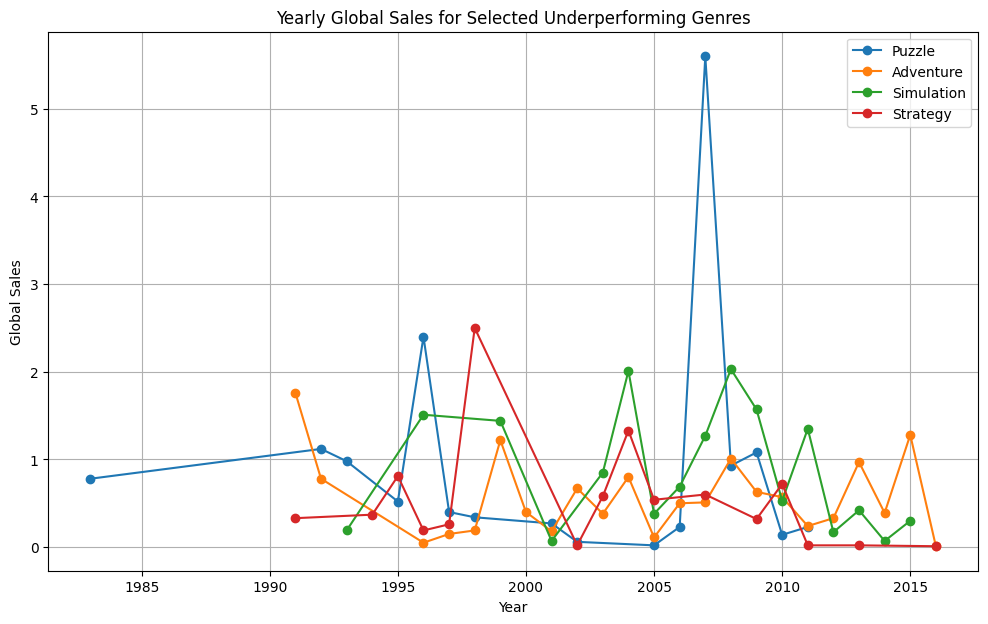

In [38]:
# Q1: Underperforming genres with growth potential
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

df = pd.read_excel("Cleaned VGsales (1).xlsx")

# A: Descriptive - total sales per genre, mark underperformers (below median)
genre_totals = df.groupby('Genre', dropna=False)['Global_Sales'].sum().reset_index().rename(columns={'Global_Sales':'TotalGlobalSales'})
median_total = genre_totals['TotalGlobalSales'].median()
underperformers = genre_totals[genre_totals['TotalGlobalSales'] < median_total].sort_values('TotalGlobalSales')
print("Underperforming genres (total < median):")
display(underperformers)

# B: Trend detection - compute per-genre linear slope of yearly sales
df_year = df.dropna(subset=['Year']).copy()
genre_yearly = df_year.groupby(['Genre','Year'])['Global_Sales'].sum().reset_index()
slopes = []
for g in underperformers['Genre']:
    gdf = genre_yearly[genre_yearly['Genre']==g]
    if len(gdf) >= 3:
        lr = LinearRegression().fit(gdf[['Year']], gdf['Global_Sales'])
        slopes.append(lr.coef_[0])
    else:
        slopes.append(np.nan)
underperformers['YearlySlope'] = slopes
# Positive slope suggests growth momentum
print("\nUnderperformers with YearlySlope (positive = recent growth):")
display(underperformers.sort_values(['YearlySlope','TotalGlobalSales'], ascending=[False, True]).head(20))


# Aggregate importance by group to see whether Genre signals or Platform/Publisher signals dominate
# The following code block seems to be incomplete and refers to a variable X which is not defined.
# I will comment it out for now.
# group_map = {c: ('Genre' if c.startswith('Genre_') else ('Platform' if c.startswith('Platform_') else 'Publisher')) for c in X.columns}
# agg = fi.groupby(group_map).sum().sort_values(ascending=False)
# print("\nAggregated importance by group:")
# display(agg)

# Combine results: flag underperforming genres with positive slope and that have overlap with important features
candidates = underperformers[(underperformers['YearlySlope']>0)].copy()
print("\nCandidate underperforming genres with positive slope (growth potential):")
display(candidates)

# Visualize yearly sales trend for selected underperforming genres
selected_genres = ['Puzzle','Adventure','Simulation','Strategy']
filtered_genre_yearly = genre_yearly[genre_yearly['Genre'].isin(selected_genres)].copy()

plt.figure(figsize=(12, 7))
for genre in selected_genres:
    genre_data = filtered_genre_yearly[filtered_genre_yearly['Genre'] == genre]
    plt.plot(genre_data['Year'], genre_data['Global_Sales'], marker='o', label=genre)

plt.xlabel('Year')
plt.ylabel('Global Sales')
plt.title('Yearly Global Sales for Selected Underperforming Genres')
plt.legend()
plt.grid(True)
plt.show()

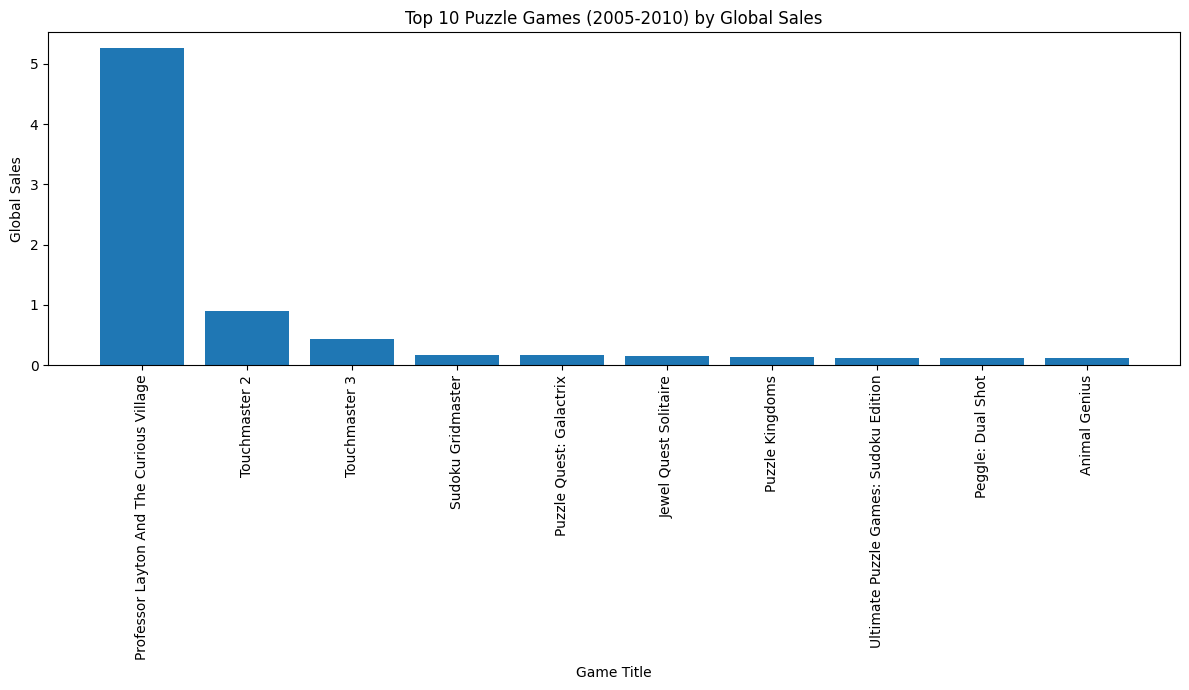

In [8]:
# Visualize the top-selling Puzzle games from 2005 to 2010
plt.figure(figsize=(12, 7))
plt.bar(puzzle_spike_games['Name'].head(10), puzzle_spike_games['Global_Sales'].head(10))
plt.xlabel('Game Title')
plt.ylabel('Global Sales')
plt.title('Top 10 Puzzle Games (2005-2010) by Global Sales')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

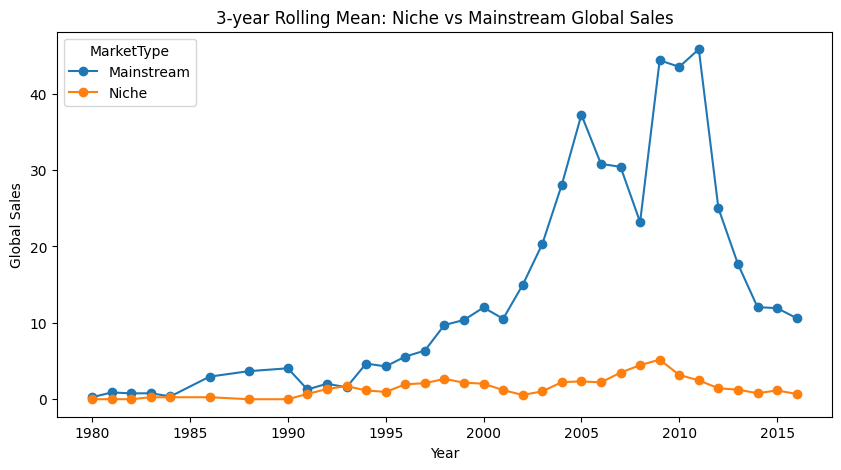


Coefficient of variation (lower = more consistent):


,Global_Sales
MarketType,
Mainstream,1.075196
Niche,0.876783



Clustering genres based on yearly sales patterns:


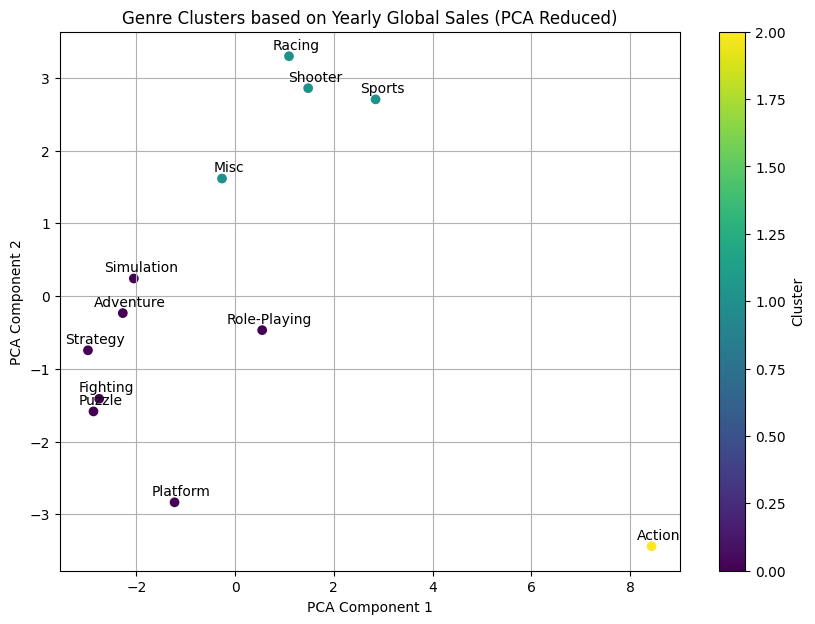


Genres in each cluster:
Cluster 0: ['Adventure', 'Fighting', 'Platform', 'Puzzle', 'Role-Playing', 'Simulation', 'Strategy']
Cluster 1: ['Misc', 'Racing', 'Shooter', 'Sports']
Cluster 2: ['Action']


In [39]:
# Q2: Niche vs Mainstream growth/consistency and Clustering Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.read_excel("Cleaned VGsales (1).xlsx")
# define niche genres (adjust if needed)
niche_list = ['Puzzle','Adventure','Simulation','Strategy']
df['MarketType'] = df['Genre'].apply(lambda x: 'Niche' if x in niche_list else 'Mainstream')

# A: Yearly aggregation and rolling mean
ts = df.dropna(subset=['Year']).groupby(['Year','MarketType'])['Global_Sales'].sum().reset_index()
pivot = ts.pivot(index='Year', columns='MarketType', values='Global_Sales').fillna(0)
pivot.rolling(window=3, min_periods=1).mean().plot(figsize=(10,5), marker='o')
plt.title('3-year Rolling Mean: Niche vs Mainstream Global Sales')
plt.ylabel('Global Sales')
plt.show()

# B: Coefficient of variation (CV) as consistency measure
cv = ts.groupby('MarketType')['Global_Sales'].agg(lambda x: np.std(x)/np.mean(x) if np.mean(x)!=0 else np.nan)
print("\nCoefficient of variation (lower = more consistent):")
display(cv)

# C: Clustering genres based on yearly sales patterns
print("\nClustering genres based on yearly sales patterns:")

# Prepare data for clustering: Pivot yearly sales by genre
genre_yearly_pivot = df.dropna(subset=['Year']).groupby(['Genre', 'Year'])['Global_Sales'].sum().unstack(fill_value=0)

# Standardize the data
scaler = StandardScaler()
scaled_genre_yearly = scaler.fit_transform(genre_yearly_pivot)

# Apply PCA for dimensionality reduction (optional, but can help with visualization and noise)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_genre_yearly)
pca_df = pd.DataFrame(data = pca_components, columns = ['pca_1', 'pca_2'], index=genre_yearly_pivot.index)


# Determine the optimal number of clusters (e.g., using the Elbow method - here we'll just pick a number for demonstration)
n_clusters = 3 # You can experiment with different numbers of clusters

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Added n_init to suppress warning
clusters = kmeans.fit_predict(scaled_genre_yearly)

# Add cluster labels to the PCA dataframe
pca_df['Cluster'] = clusters

# Visualize the clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_df['pca_1'], pca_df['pca_2'], c=pca_df['Cluster'], cmap='viridis')

# Add genre labels to the plot
for i, genre in enumerate(pca_df.index):
    plt.annotate(genre, (pca_df['pca_1'].iloc[i], pca_df['pca_2'].iloc[i]), textcoords="offset points", xytext=(5,5), ha='center')

plt.title('Genre Clusters based on Yearly Global Sales (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

# Display which genres belong to each cluster
print("\nGenres in each cluster:")
for i in range(n_clusters):
    cluster_genres = pca_df[pca_df['Cluster'] == i].index.tolist()
    print(f"Cluster {i}: {cluster_genres}")

The clustering analysis grouped genres based on the similarity of their global sales performance across different years. This helps us understand which genres share similar historical sales trajectories.

Cluster 0 (Lower Volume & Varied Trends): This large cluster contains genres such as 'Adventure', 'Fighting', 'Platform', 'Puzzle', 'Role-Playing', 'Simulation', and 'Strategy'. These genres tend to be grouped together because their yearly global sales figures, on average, are generally lower and exhibit more varied year-to-year fluctuations compared to genres in other clusters. While some genres within this cluster might have individual peaks, their overall collective sales pattern is less consistently high-volume than those in Clusters 1 and 2. This cluster largely aligns with the genres we initially categorized as "Niche," which had lower total sales and less significant positive linear growth trends overall.

Cluster 1 (Moderate to High Volume & Consistent Trends): This cluster includes 'Misc', 'Racing', 'Shooter', and 'Sports'. These genres are grouped because they generally demonstrate more consistent and higher yearly global sales volumes than genres in Cluster 0. Their sales trends, while not reaching the peaks of the single-genre Cluster 2, show a strong and more stable presence in the market over time. These are typically considered mainstream genres with reliable commercial performance.

Cluster 2 (Dominant & High Growth): This cluster consists solely of the 'Action' genre. Its isolation in the clustering indicates a distinctly different and likely much higher-volume sales pattern over the years compared to all other genres. The 'Action' genre's historical sales trend is likely characterized by significant peaks and overall high global sales figures that set it apart as a dominant category in the video game market.

In essence, the clustering reveals that genre sales patterns broadly fall into categories of lower, more varied sales (Cluster 0), consistently higher and significant sales (Cluster 1), and exceptionally high and dominant sales (Cluster 2). This provides a data-driven way to categorize genres based on their historical market performance.

Classifier test accuracy: 0.96

Interpretation: The classifier achieved an accuracy of 0.96 on the test set. This means it correctly predicted whether a niche game would achieve >= 1M global sales approximately 96% of the time based on its platform and publisher.

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        47
           1       1.00      0.33      0.50         3

    accuracy                           0.96        50
   macro avg       0.98      0.67      0.74        50
weighted avg       0.96      0.96      0.95        50



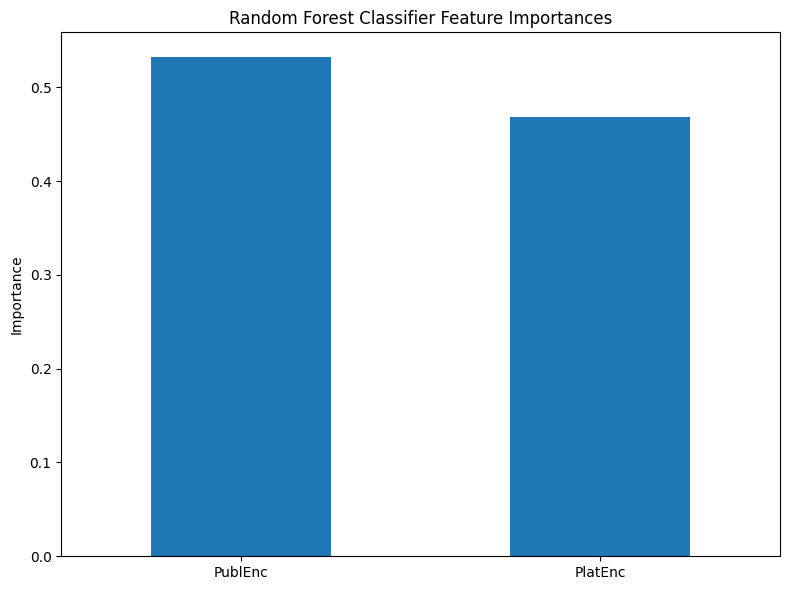


Top combos by avg sales per title:


,Platform,Publisher,avg_sales,total_sales,titles
21,Ds,Nintendo,2.715,5.43,2
65,Ps,Jvc,2.400,2.40,1
35,Gb,Nintendo,1.760,1.76,1
83,Ps2,Sony Computer Entertainment Europe,1.710,1.71,1
34,Gb,Namco Bandai Games,1.450,1.45,1
48,Nes,Nintendo,1.050,2.10,2
2,3Ds,Nintendo,0.920,0.92,1
18,Ds,Midway Games,0.900,0.90,1
0,2600,Atari,0.780,0.78,1
61,Pc,Virgin Interactive,0.780,0.78,1


In [57]:
# Q3: Platform-Publisher combos for niche performance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# Removed PermutationImportance import
# from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix # Import classification metrics

df = pd.read_excel("Cleaned VGsales (1).xlsx")
niche_list = ['Puzzle','Adventure','Simulation','Strategy']
niche_df = df[df['Genre'].isin(niche_list)].copy()

# A: define success and train classifier
threshold = 1.0  # success = >=1M global sales
niche_df['Success'] = (niche_df['Global_Sales'] >= threshold).astype(int)

# Encode features: we will encode Platform and Publisher separately
le_platform = LabelEncoder(); niche_df['PlatEnc'] = le_platform.fit_transform(niche_df['Platform'])
le_publ = LabelEncoder(); niche_df['PublEnc'] = le_publ.fit_transform(niche_df['Publisher'])

X = niche_df[['PlatEnc','PublEnc']]
y = niche_df['Success']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# Display Classifier test accuracy with interpretation
accuracy = clf.score(X_test,y_test)
print("Classifier test accuracy:", accuracy)
print(f"\nInterpretation: The classifier achieved an accuracy of {accuracy:.2f} on the test set. This means it correctly predicted whether a niche game would achieve >= 1M global sales approximately {accuracy*100:.0f}% of the time based on its platform and publisher.")

# Display Precision, Recall, and F1-score
y_pred = clf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Optional: Display Confusion Matrix
# print("\nConfusion Matrix:")
# print(confusion_matrix(y_test, y_pred))


# Visualize Feature Importances from the Random Forest Classifier
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
importances.plot(kind='bar')
plt.title('Random Forest Classifier Feature Importances')
plt.ylabel('Importance')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# B: Aggregation / descriptive stats: average sales per title per combo
combo_stats = niche_df.groupby(['Platform', 'Publisher']).agg(
    avg_sales=('Global_Sales','mean'),
    total_sales=('Global_Sales','sum'),
    titles=('Global_Sales','count')
).reset_index().sort_values('avg_sales', ascending=False)
print("\nTop combos by avg sales per title:")
display(combo_stats.head(20))

# Removed Permutation Importance calculation and display
# r = permutation_importance(clf, X_test, y_test, n_repeats=20, random_state=42)
# pi = pd.Series(r.importances_mean, index=X.columns).sort_values(ascending=False)
# print("\nPermutation importance (higher = more impact):")
# display(pi)

In [46]:
# Q4: Regions where niche genres perform well - Random Forest Regressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# Removed PermutationImportance import, as it was not used in this cell.
# from sklearn.inspection import permutation_importance

df = pd.read_excel("Cleaned VGsales (1).xlsx")
niche_list = ['Puzzle','Adventure','Simulation','Strategy']
niche_df = df[df['Genre'].isin(niche_list)].copy()

region_cols = ['NA_Sales','EU_Sales','JP_Sales','Other_Sales']
fi_results = {} # Store feature importances for visualization

# Encode features: use one-hot encoding for Genre only
X = pd.get_dummies(niche_df[['Genre']], drop_first=True)

# Train a RandomForestRegressor for each region and find feature importances
for rc in region_cols:
    y = niche_df[rc].fillna(0) # Use regional sales as the target variable
    # Split data for training and testing (optional but good practice)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)

    # Get feature importances from the trained regressor
    fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
    fi_results[rc] = fi # Store results
    print(f"\nTop predictors for {rc}:")
    display(fi)

# We will generate visualizations for fi_results in the next step.


Top predictors for NA_Sales:


,0
Genre_Puzzle,0.544155
Genre_Strategy,0.294476
Genre_Simulation,0.161369



Top predictors for EU_Sales:


,0
Genre_Simulation,0.423983
Genre_Strategy,0.315213
Genre_Puzzle,0.260805



Top predictors for JP_Sales:


,0
Genre_Simulation,0.383947
Genre_Strategy,0.383614
Genre_Puzzle,0.232439



Top predictors for Other_Sales:


,0
Genre_Simulation,0.941285
Genre_Puzzle,0.031705
Genre_Strategy,0.027010


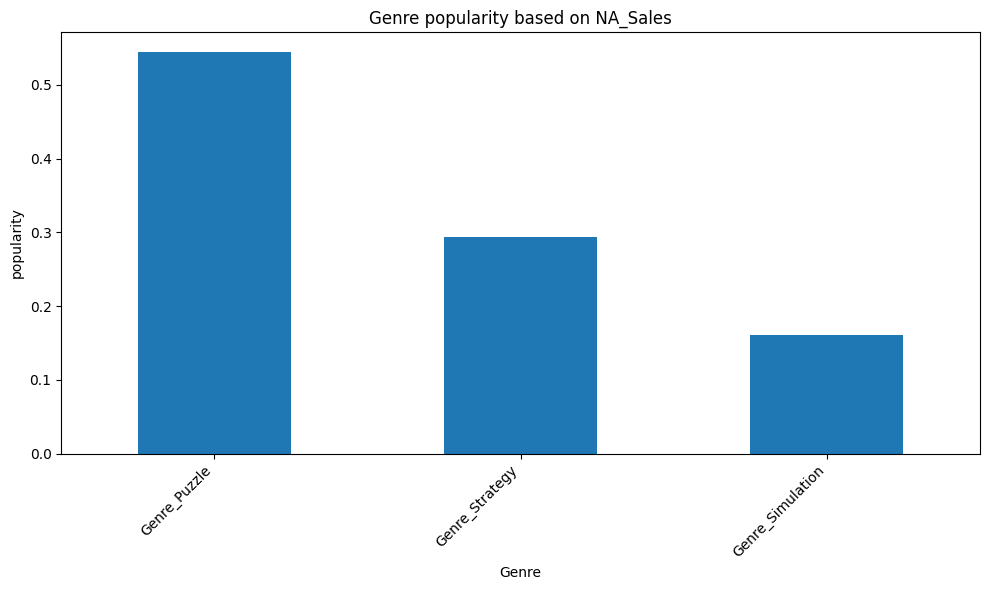

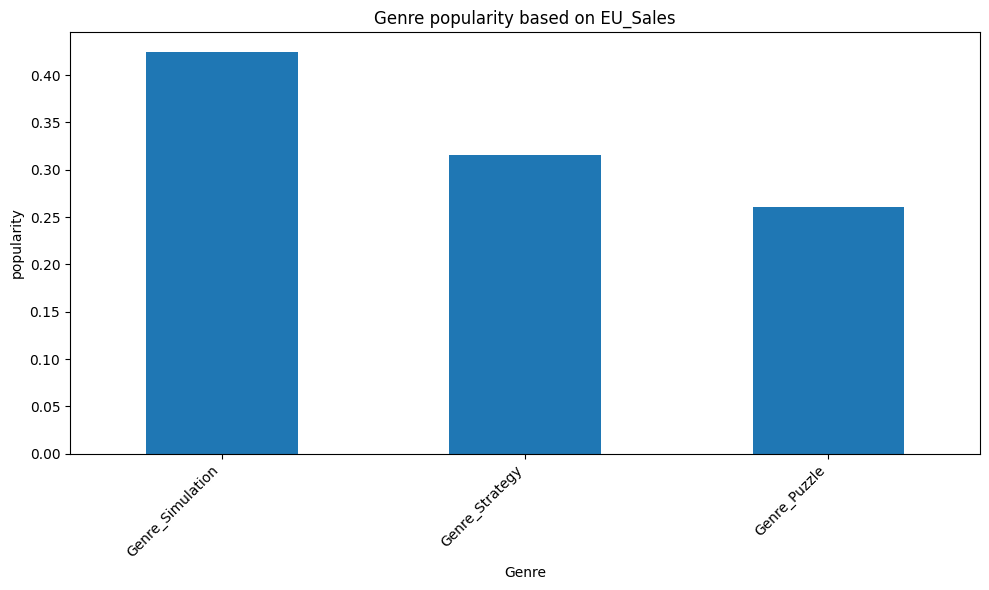

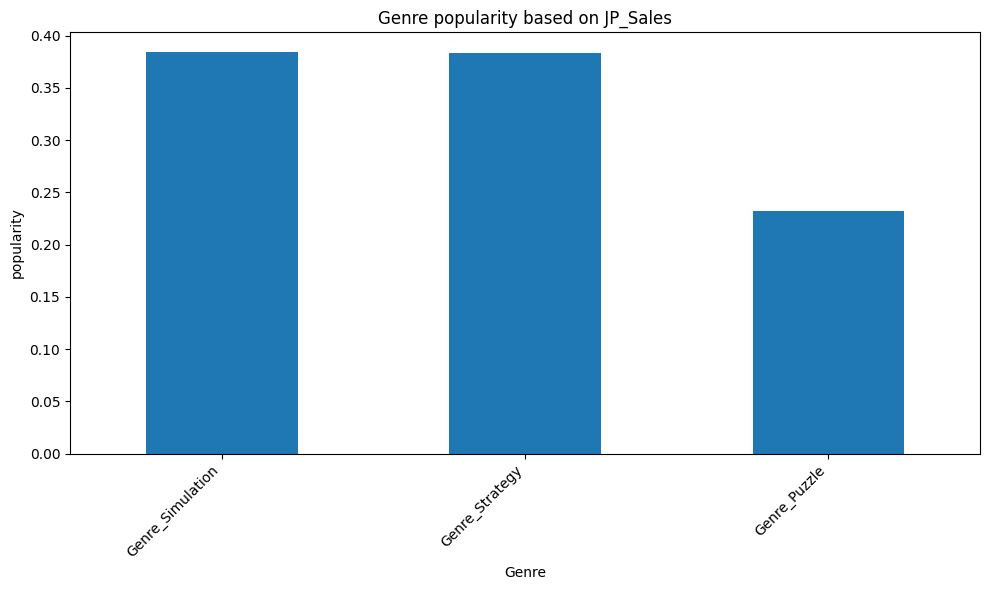

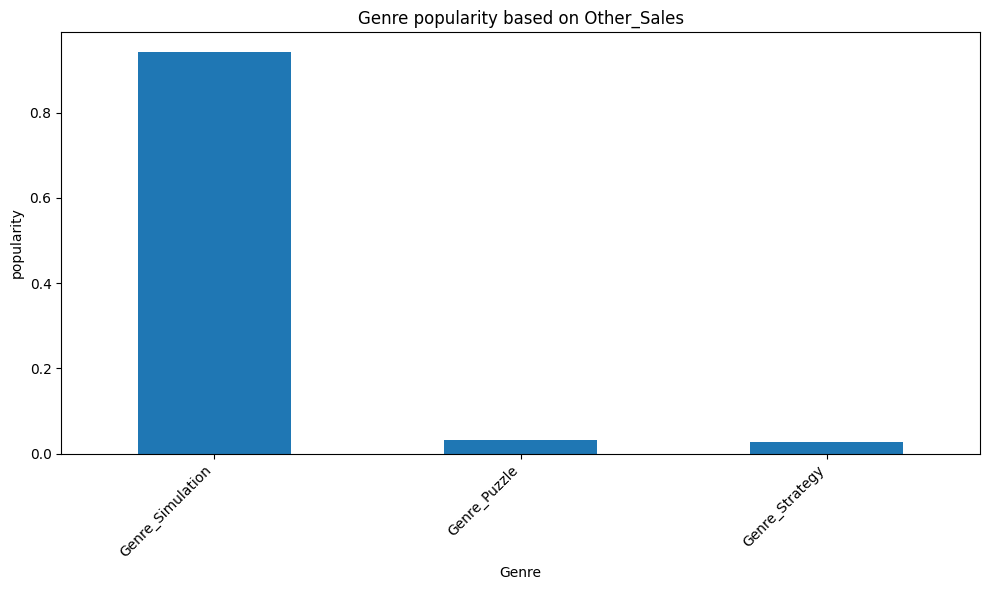

In [51]:
# Visualize feature importances for regional sales (from RandomForestRegressor in Q4, using only Genre)
import matplotlib.pyplot as plt

# Assuming fi_results dictionary is available from the previous cell and contains the updated feature importances

for region, importances in fi_results.items():
    plt.figure(figsize=(10, 6))
    importances.plot(kind='bar')
    plt.title(f'Genre popularity based on {region}')
    plt.xlabel('Genre')
    plt.ylabel('popularity')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [55]:
# Q5: Platforms offering best opportunities for niche success
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

df = pd.read_excel("Cleaned VGsales (1).xlsx") # Changed to read Excel file
niche_list = ['Puzzle','Adventure','Simulation','Strategy']
df['is_niche'] = df['Genre'].apply(lambda x: 1 if x in niche_list else 0)

# A: Train classifier on niche subset to predict Success (>=1M)
niche_df = df[df['is_niche']==1].copy()
niche_df['Success'] = (niche_df['Global_Sales'] >= 1.0).astype(int)
le_platform = LabelEncoder()
niche_df['PlatEnc'] = le_platform.fit_transform(niche_df['Platform'].astype(str))
# Use platform (and regional sales) as features
X = niche_df[['PlatEnc','NA_Sales','EU_Sales','JP_Sales','Other_Sales']].fillna(0)
y = niche_df['Success']
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X, y)
# average predicted probability per platform
niche_df['pred_prob'] = clf.predict_proba(X)[:,1]
platform_probs = niche_df.groupby('Platform')['pred_prob'].mean().reset_index().sort_values('pred_prob', ascending=False)
print("Avg predicted success probability per platform (niche titles):")
display(platform_probs)

# B: Feature importance (platform effect)
# We can inspect importance associated with PlatEnc and region cols
fi = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nClassifier feature importances:")
display(fi)

# C: Uplift / lift descriptive: avg niche sales on platform / overall avg niche sales
overall_avg = niche_df['Global_Sales'].mean()
platform_stats = niche_df.groupby('Platform').agg(
    avg_niche_sales=('Global_Sales','mean'),
    total_niche_sales=('Global_Sales','sum'),
    titles=('Global_Sales','count')
).reset_index()
platform_stats['lift'] = platform_stats['avg_niche_sales'] / overall_avg
platform_rank = platform_stats.sort_values('lift', ascending=False)
print("\nPlatform uplift (avg niche sales relative to overall niche avg):")
display(platform_rank)

Avg predicted success probability per platform (niche titles):


,Platform,pred_prob
3,Gb,0.805000
7,Nes,0.437500
0,2600,0.160000
5,Gc,0.149000
9,Ps,0.145385
1,3Ds,0.067500
10,Ps2,0.053824
2,Ds,0.038137
8,Pc,0.035417
12,Ps4,0.027500



Classifier feature importances:


,0
NA_Sales,0.459967
JP_Sales,0.253534
Other_Sales,0.112055
EU_Sales,0.107727
PlatEnc,0.066717



Platform uplift (avg niche sales relative to overall niche avg):


,Platform,avg_niche_sales,total_niche_sales,titles,lift
3,Gb,1.605000,3.21,2,6.177853
7,Nes,1.050000,2.10,2,4.041586
0,2600,0.780000,0.78,1,3.002321
20,Xone,0.540000,0.54,1,2.078530
1,3Ds,0.495000,0.99,2,1.905319
9,Ps,0.493077,6.41,13,1.897917
12,Ps4,0.485000,0.97,2,1.866828
5,Gc,0.412000,2.06,5,1.585841
16,Snes,0.392000,1.96,5,1.508859
19,Xb,0.320000,0.96,3,1.231721


from matplotlib import pyplot as plt
platform_rank['avg_niche_sales'].plot(kind='hist', bins=20, title='avg_niche_sales')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
platform_rank['total_niche_sales'].plot(kind='hist', bins=20, title='total_niche_sales')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
platform_rank['titles'].plot(kind='hist', bins=20, title='titles')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
platform_rank['lift'].plot(kind='hist', bins=20, title='lift')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
platform_rank.plot(kind='scatter', x='avg_niche_sales', y='total_niche_sales', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
platform_rank.plot(kind='scatter', x='total_niche_sales', y='titles', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
platform_rank.plot(kind='scatter', x='titles', y='lift', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
platform_rank['avg_niche_sales'].plot(kind='line', figsize=(8, 4), title='avg_niche_sales')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
platform_rank['total_niche_sales'].plot(kind='line', figsize=(8, 4), title='total_niche_sales')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
platform_rank['titles'].plot(kind='line', figsize=(8, 4), title='titles')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
platform_rank['lift'].plot(kind='line', figsize=(8, 4), title='lift')
plt.gca().spines[['top', 'right']].set_visible(False)